In [1]:
# default_exp data.core 

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# hide
from nbdev.showdoc import *

# Data Core

> Using the fastai2 `Datasets` to make an time series dataset.


In [4]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastseq.data.load import *
from fastseq.data.procs import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
import orjson

In [5]:
# hide
# just check previous nb still works. Sometimes import errors
horizon,lookback = 2,5
path = Path('../data/test_data')
del_create([160,160,160],path = path)
dl = MTSDataLoader.from_path(path, y_name = 'x', lookback= lookback, horizon = horizon)
test_eq(dl.n, len(dl._ids))
test_eq(dl.n, 462)
test_eq(len(dl),8)
for o in dl:pass

# Transforms

> Basic function to process time-series data before assembling it in a `DataLoaders`.

## Normalize

In [6]:
# export
def _zeros_2_ones(o, eps=1e-8):
    nan_mask = o!=o
    o[o < eps ] = 1    
    o[nan_mask ] = 1    
    return o
    

In [7]:
o = np.arange(0,1,.1)
test_close(list(_zeros_2_ones(o,.5)),[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9])

o = np.arange(0,1,.1)[None,:]
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]])

o = torch.arange(0,1,.1)[None,:]
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]]))

o = torch.arange(0,1,.1)[None,:]
o[:,-1]= torch.tensor(float('nan'))
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]]))

o = np.arange(0,1,.1)[None,:]
o[:,-1]= np.nan
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]])

/home/tako/dev/env37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


### old

In [8]:
import warnings
class NormalizeTSMulti(ItemTransform):
    "Normalize the Time-Series."
    def __init__(self, to_norm=['TensorCon','TensorSeq'], verbose=False, make_ones=True, eps=1e-7, mean = None):
        """
        `make_ones` will make the std 1 if the std is smaller than `10*eps`.
        This is for blok seqences to not magnify the `y` part of the data.

        `mean` will set a mean instead of the mean of the x value.
        (
            TensorSeqs(x, label=[self.y_name + '_x'], m=['g']),
            TensorSeqs(tsx,label=self.ts_names),
            TensorCon(cat,label=self.cat_names).long(),
            TensorCon(con,label=self.con_names),
            TensorSeqs(y, label=[self.y_name+ '_y'], m=['r'])
        )
        """
        store_attr(self,'verbose, make_ones, eps, mean,to_norm')
        self.m, self.s = {}, {}
        warnings.warn("NormalizeTSMulti is depricated. Please use `NormalizeSeqsMulti`")

    def encodes(self, o):
        for i in range(len(o)-1):
            self.m[i], self.s[i] = 0, 1
            if type(o[i]) == TensorCon and o[i].shape[-1]>0: # if tensor has shape (bs,0) than ignore
                if 'TensorCon' in self.to_norm:
                    self.m[i] = torch.mean(o[i])
                    self.s[i] = torch.std(o[i]) + self.eps 
            elif type(o[i]) == TensorSeq:
                if 'TensorSeq' in self.to_norm:
                    self.m[i] = torch.mean(o[i], -1, keepdim=True)
                    self.s[i] = torch.std(o[i],  -1, keepdim=True) +self.eps
                    self.s[i] = _zeros_2_ones(self.s[i], self.eps*10)
            elif self.verbose:
                if o[i].shape[-1]>0 and not type(o[i]) == TensorCatI:
                    print(f'NormalizeTSMulti:type {type(o[i])} on location:{i}/{len(o)} of tuple not found')
                
        # y must be scaled with m
        self.m[len(o)-1], self.s[len(o)-1] = self.m[0],self.s[0] 
        # TODO make y its own type
        if self.verbose:
            print('encodes',[a.shape for a in o],'m shape', {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
        
        return TSMulti_([(o[i]-self.m[i]) / self.s[i] for i in range(len(o))])       
    
    def decodes(self, o):
        if o[0].is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
            if sum([a.is_cuda for a in o]) != len(o):
                o = Tuple([to_device(a,'cuda') for a in o])
        else:
            if sum([a.is_cuda==False for a in o]) != len(o):
                o = Tuple([to_cpu(a) for a in o])
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)
        if self.verbose:
            print('decodes',[a.shape for a in o],  {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
        return TSMulti_([(o[i]*self.s[i])+self.m[i] for i in range(len(o))])

In [9]:
o = TSMulti_(TensorSeq(np.arange(12.)),1,2,TensorSeq(np.arange(-1,11.)))
tmf = NormalizeTSMulti()
o_tmf = tmf(o)


/home/tako/dev/env37/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: NormalizeTSMulti is depricated. Please use `NormalizeSeqsMulti`


In [10]:
%%timeit
o_tmf = tmf(o)

432 µs ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### new

In [11]:
# export
class NormalizeSeq(Transform):
    def __init__(self, verbose=False, make_ones=True, eps=1e-7, mean = None):
        store_attr(self,'verbose, make_ones, eps, mean')
        self.m, self.s = 0, 1
        
    def to_same_device(self, o):    
        if o.is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
        else:
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)     
            
    def encodes(self, o: TensorSeq):
        self.m = torch.mean(o, -1, keepdim=True)
        self.s = torch.std(o,  -1, keepdim=True) +self.eps
        if (self.s < self.eps*10).sum():
            self.s = _zeros_2_ones(self.s, self.eps*10)
        if self.verbose:
            print('encodes',[a.shape for a in o],
                  'm shape', {k:o.shape for k,o in self.m.items()},
                  's shape',{k:o.shape for k,o in self.s.items()})
        
        return self.norm(o)
    
    def norm(self, o):
        return (o - self.m)/self.s
    
    def decodes(self, o: TensorSeq):
        if self.verbose:
            print('decodes',o.shape,  
                  'm shape',self.m.shape,
                  's shape',self.s.shape)
        return self.denorm(o)
    
    def denorm(self, o):
        self.to_same_device(o)
        return (o*self.s)+self.m 

In [12]:
tmf = NormalizeSeq()
o = TensorSeq(TensorSeq([np.arange(12.)]*16))
o_tmf = tmf(o)
test_close(o_tmf.mean(),0)
test_eq(tmf.decode(o_tmf),TensorSeq([np.arange(12.)]*16))

In [13]:
# export
class NormalizeSeqMulti(ItemTransform):
    """A shell Transformer to normalize `TensorSeqs` inside `TSMulti_` with `NormalizeSeqs`. """
    @delegates(NormalizeSeq.__init__)
    def __init__(self, n_its=5, **kwargs):
        """`n_its` does not include the ts to predict."""
        self.f = {i:NormalizeSeq(**kwargs) for i in range(n_its)}
        self.n = n_its
        
    def encodes(self, o):
        r = L()
        for i,a in enumerate(o):
            if type(a) is not TensorSeq:
                r.append(a)
            elif i < (self.n-1):
                r.append(self.f[i](a))
            else:
                r.append(self.f[0].norm(o[i]))
        return TSMulti_(r)
    
    def decodes(self, o): 
        r = L(self.f[i].decode(a) for i,a in enumerate(o[:-1]))
        r.append(self.f[0].denorm(o[-1]))
        return TSMulti_(r)
    

In [14]:
o = TSMulti_(TensorSeq([np.arange(12.)]*16),
             [1]*16,
             [2]*16,
             TensorSeq([np.arange(-2,10.)]*16))
tmf = NormalizeSeqMulti(len(o))
o_tmf = tmf(o)
test_close(o_tmf[0].mean(),0)
test_eq(o_tmf[1], o[1])
test_eq(torch.round(o_tmf[3].mean()), -1)

In [15]:
o = TSMulti_(TensorSeq([[np.arange(12.)]]*16),
             [1]*16,
             [2]*16,
             TensorSeq([[np.arange(-2,10.)]]*16))
tmf = NormalizeSeqMulti(len(o))
o_tmf = tmf(o)
test_close(o_tmf[0].mean(),0)
test_eq(o_tmf[1], o[1])
test_eq(torch.round(o_tmf[3].mean()), -1)

In [16]:
o = TSMulti_(TensorSeq(np.arange(12.)),1,2,TensorSeq(np.arange(-1,11.)))
tmf = NormalizeSeqMulti(len(o))
o_tmf = tmf(o)

test_close(o_tmf[0].mean(),0);test_close(o_tmf[0].std(),1);
test_eq(o_tmf[1],1)
test_eq(o_tmf[2],2)
# Note the y has not mean 0 because it is normalized with the stats of the first item in the tuple
test_close(o_tmf[3].mean(),-0.27,.1); test_close(o_tmf[3].std(),1); 
test_eq(tmf.decode(o_tmf), o)
def prof_func():
    tmf(o)

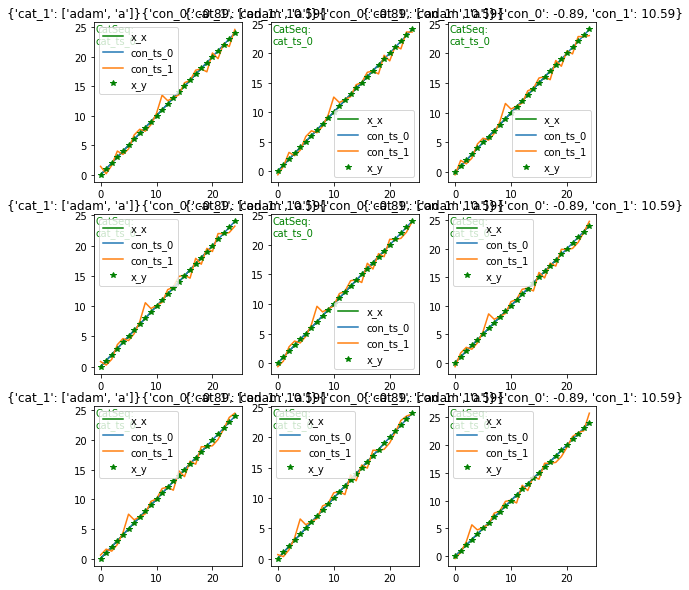

In [17]:
path = Path('../data/test_data')

dl = MTSDataLoader.from_path(path, y_name = 'x', lookback = 20, horizon = 5, num_workers = 0,
                            after_batch = NormalizeSeqMulti())
dl.show_batch()

In [18]:
# hide
for o in dl:
    for a in o[:-1]:
        if a.shape[-1] > 0 and type(a) is TensorSeq:    
            test_close(a.mean(-1), 0)
            test_close(a.std(),1, .1)
    test_close(o[0][:,:,:lookback],o[-1][:,:,:lookback],.1)
    test_eq(type(o),TSMulti_)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    break
    
test_eq(type(dl.one_batch()), TSMulti_)

# TSDataLoaders

## Utils

In [19]:
# export 
def make_test(ts:dict, horizon:int, lookback:int, keep_lookback:bool = False):
    """Splits the every ts in `items` based on `horizon + lookback`*, 
    where the last part will go into `val` and the first in `train`.
    *if `keep_lookback`:
        it will only remove `horizon` from `train` otherwise will also remove lookback from `train`.
    """
    train, val = {}, {}
    for k,v in ts.items():
        if k in ['ts_con','ts_cat']:
            if keep_lookback:
                train[k] = {col:o[:-(horizon)] for col, o in v.items()}                
            else:                    
                train[k] = {col:o[:-(horizon+lookback)] for col, o in v.items()}
            val[k] = {col: o[-(horizon+lookback):] for col, o in v.items()}        
            
        elif k == '_length':
            train[k] = v - (horizon if keep_lookback else horizon+lookback)
            val[k] = horizon+lookback
        else:
            train[k] = v
            val[k] = v   
    return train, val

In [20]:
horizon,lookback = 2,5
df = get_df([14, 14, 16])
path = Path('../data/test_data')
save_df(df, path)
ts = get_ts_datapoint(get_files(path, extensions='.json')[0])
train, val = make_test(ts, horizon, lookback, True)

for k,v in train['ts_con'].items():
    test_eq(train['ts_con'][k],ts['ts_con'][k][:-(horizon)])
for k,v in val['ts_con'].items():
    test_eq(val['ts_con'][k],ts['ts_con'][k][-(horizon+lookback):])
    
train, val = make_test(ts,horizon,lookback, False)
for key in train['ts_con'].keys():
    test_eq(train['ts_con'][key], ts['ts_con'][key][:-(horizon+lookback)])
for key in val['ts_con'].keys():
    test_eq(val['ts_con'][key], ts['ts_con'][key][-(horizon+lookback):])

In [21]:
# export
def _ts_file_names(file, valid_folder='valid', train_folder = 'train',
               post_fix = True, path = None, **kwargs):
    path = ifnone(path, Path(*str(file).split(os.sep)[:-1]))
    for folder, name in zip([train_folder, valid_folder], ['train','val']):
        p = path if folder is None else path / folder
        new_f =  p / file.name
        if new_f.exists() and post_fix: 
            new_f = Path(str(new_f).replace('.json', '_' + name + '.json'))
        if not new_f.parent.exists(): new_f.parent.mkdir()
        yield new_f

@delegates(make_test)
def split_file(file, valid_folder='valid', train_folder = 'train',
               post_fix = True, path = None, **kwargs):
    ts = get_ts_datapoint(file)
    t, v = make_test(ts, **kwargs)   
    # in the new folder
    r = []
    for part, new_f  in zip([t,v], _ts_file_names(file, valid_folder, train_folder,
                                              post_fix, path = path)):
        open(new_f,'wb').write(orjson.dumps(part)) 
        r.append(new_f)
    return r

In [22]:
horizon,lookback = 2,5
df = get_df([14, 14, 16])
path = Path('../data/test_data')
save_df(df, path)
r = split_file(get_files(path, extensions='.json')[0], horizon=horizon, lookback=lookback, train_folder = None)
assert Path('../data/test_data/2_train.json') in r

In [23]:
def multithread_f(f,o:list, num_workers = None):
    from multiprocessing.dummy import Pool as ThreadPool
    pool = ThreadPool(num_workers)    
    r = pool.map(f, o)
    return r
    

In [24]:
# export
@delegates(split_file)
def TSSplitter(**kwargs):
    "Create function that splits `items` between train/val."
    def _inner(o):
        return split_file(o, **kwargs)
    return _inner

In [25]:
horizon,lookback = 2,5
df = get_df([14, 14, 16])
path = Path('../data/test_data')
save_df(df, path)
f = TSSplitter(horizon=horizon, lookback=lookback)
r = multithread_f(f, get_files(path, extensions='.json', folders=False))

In [26]:
# export
from typing import List
@delegates(TSSplitter)
def _exe_splitter(files:List[Path], horizon, lookback, valid_pct, splitter=None, num_workers = None,
                 **kwargs):
    splitter = ifnone(splitter, TSSplitter(horizon= horizon + int(valid_pct*horizon),lookback=lookback,
                                **kwargs))
#     print('Excecuting splitter; estimated time:', _time_it(splitter, files[0])*len(files)) 

    list(_ts_file_names(files[0], **kwargs))
    r = multithread_f(splitter, files, num_workers = num_workers)        
    return [o[0] for o in r], [o[1] for o in r]

def _get_train_valid_files(path):
    if (path / 'train').exists():
        train = get_files(path / 'train', extensions='.json', folders = False)
    else:
        train = get_files(path, extensions='.json', folders = False)
    valid = get_files(path / 'valid', extensions='.json', folders = False)
    return train, valid

@delegates(_exe_splitter)
def get_train_valid_ts(path, **kwargs):    
    if (path / 'valid').exists():
        train, valid = _get_train_valid_files(path)
    else:
        files = get_files(path, extensions='.json', folders = False)
        train, valid = _exe_splitter(files, **kwargs)
    return train, valid



In [27]:
path = Path('../data/test_data')
if (path / 'valid').exists():
    for f in path.glob('valid'+os.sep+'*'):
        f.unlink()
    (path / 'valid').rmdir()
if (path / 'train').exists(): 
    for f in path.glob('train'+os.sep+'*'):
        f.unlink()
    (path / 'train').rmdir()
    
df = get_df([160, 160, 160])
path = Path('../data/test_data')
path.delete()
path.mkdir()
save_df(df, path)
train, valid = get_train_valid_ts(path, horizon = horizon, lookback = lookback,valid_pct= 1.5)
test_eq(len(train),len(valid))
test_eq(get_ts_datapoint(train[0]).keys(), get_ts_datapoint(valid[0]).keys())

train, valid = get_train_valid_ts(path, horizon = horizon, lookback = lookback, valid_pct= 1.5)
test_eq(len(train),len(valid))
test_eq(get_ts_datapoint(train[0]).keys(),get_ts_datapoint(valid[0]).keys())

### Split into M5 parts

In [28]:
# export
def split_for_m5(path, lookback, horizon = 28, verbose = False):
    """Splits al the files in:
        - Evaluation (`horizon` + `lookback`),
        - Validation (`horizon` + `lookback`),
        - val (`horizon` + `lookback` + 'val_pct' * `horizon`),
        - train (the rest) 
        """
    
    if ((path / 'evaluation').exists() and (path / 'validation').exists() and 
        (path / 'val').exists() and (path / 'train').exists()):
        evalu = get_files(path / 'evaluation', extensions='.json', folders = False)
        validation = get_files(path / 'validation', extensions='.json', folders = False)
        val = get_files(path / 'val', extensions='.json', folders = False)
        train = get_files(path / 'train', extensions='.json', folders = False)
        
    else:
        files = get_files(path, extensions='.json', folders = False) 
        (files[0].parent / 'all').mkdir()
        for f in files:
            f.copy(f.parent / 'all' / f.name)
        if verbose: print('moved to all')
        train, evalu = _exe_splitter(files, horizon = horizon, lookback= lookback, valid_pct=0,
                                     splitter = None, keep_lookback=True,
                                     valid_folder='evaluation', train_folder = None, 
                                     post_fix = False, path = path)        
        if verbose: print('made evalutation')
        train, validation = _exe_splitter(train, horizon = horizon, lookback= lookback,valid_pct=0,
                                          splitter = None, keep_lookback=True,
                                          valid_folder='validation', train_folder = None,
                                          post_fix = False, path = path)        
        if verbose: print('made validation')
        
        train, val = _exe_splitter(train, horizon = horizon, lookback= lookback,valid_pct=2,
                                   splitter = None, keep_lookback=True,
                                   valid_folder='val', train_folder = 'train',
                                   post_fix = False, path = path)        
        if verbose: print('made val')
        
        for f in Path(files[0].parent / 'all').glob('*.json'):
            f.rename(files[0].parent / f.name)
        shutil.rmtree(Path(files[0].parent / 'all'))
        
    return train, val, validation, evalu


In [29]:
df = get_df([100, 100, 100])
path = Path('../data/test_data')
path.delete()
path.mkdir()
save_df(df, path)
train, val, validation, evalu = split_for_m5(path, 10, 5, verbose = True)

for files, length, m in zip([train, val, validation, evalu],[75, 25, 15, 15], [74, 89, 94, 99]):
    ts = get_ts_datapoint(files[0])
    test_eq(ts['_length'], length)
    test_eq(max(ts['ts_con']['con_ts_0']), m)
    
ts = get_ts_datapoint(get_files(path, extensions='.json', folders = False)[0])
test_eq(ts['_length'], 100)
test_eq(max(ts['ts_con']['con_ts_0']), 99)

moved to all
made evalutation
made validation
made val


## Dataloaders

In [33]:
#export
class MTSDataLoaders(DataLoaders):    
    @classmethod
    @delegates(MTSDataLoader.__init__)    
    def _from_folders_list(cls, folders:List[List[Path]], y_name:str, horizon:int, lookback=None, step=1,
                           device=None, norm=True, valid_pct=1.5, splitter = None,
                           procs = None, vocab=None, o2i=None, path = None, **kwargs):        
        lookback = ifnone(lookback, horizon * 3)
        device = ifnone(device, default_device())
        path = ifnone(path, folders[0][0].parent.parent)
        if procs:
            p = Pipeline(*procs)
            for files in folders:
                p(files)
        if norm and 'after_batch' not in kwargs:            
            kwargs.update({'after_batch':L(NormalizeSeqMulti(n_its=5))})     
            
        db = DataLoaders(*[MTSDataLoader(ds, get_meta(path), y_name, horizon=horizon, lookback=lookback, step=step,
                                        device=device, vocab=vocab, o2i=o2i, **kwargs)
                           for ds in folders], path=path, device=device)
        
        print({k:db[i].n for i,k in zip(range(len(folders)),
                                        ['Train','Val','Validation','Evaluation',*['ds_'+str(j) for j in range(4,100)]])})
        return db

@delegates(MTSDataLoaders._from_folders_list)
def from_m5_path(cls, path:Path, y_name:str, horizon:int, lookback = None, verbose = False, procs = [], **kwargs):
    """Create `MTSDataLoaders` from a path. 
    Defaults to splitting the data according to the M5 compitetion.    
    """    
    lookback = ifnone(lookback, horizon * 3)
    vocab, o2i = make_vocab(path)                
    train, val, validation, evalu = split_for_m5(path, lookback, horizon, verbose = verbose)
    procs = L(procs) + CatProc(path, vocab = vocab, o2i = o2i)
    return cls._from_folders_list(folders = [train, val, validation, evalu],
                                  y_name= y_name, horizon= horizon, lookback = lookback, 
                                  vocab=vocab, o2i=o2i, path = path, 
                                  procs = procs,**kwargs)
MTSDataLoaders.from_m5_path = classmethod(from_m5_path)


In [34]:
show_doc(MTSDataLoaders.from_m5_path, name='MTSDataLoaders.from_m5_path' )

<h4 id="MTSDataLoaders.from_m5_path" class="doc_header"><code>MTSDataLoaders.from_m5_path</code><a href="__main__.py#L26" class="source_link" style="float:right">[source]</a></h4>

> <code>MTSDataLoaders.from_m5_path</code>(**`path`**:`Path`, **`y_name`**:`str`, **`horizon`**:`int`, **`lookback`**=*`None`*, **`verbose`**=*`False`*, **`procs`**=*`[]`*, **`step`**=*`1`*, **`device`**=*`None`*, **`norm`**=*`True`*, **`valid_pct`**=*`1.5`*, **`splitter`**=*`None`*, **`vocab`**=*`None`*, **`o2i`**=*`None`*, **`min_seq_len`**=*`None`*, **`train`**=*`True`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create [`MTSDataLoaders`](/fastseq/data.core#MTSDataLoaders) from a path. 
Defaults to splitting the data according to the M5 compitetion.    

{'Train': 33, 'Val': 45, 'Validation': 3, 'Evaluation': 3}


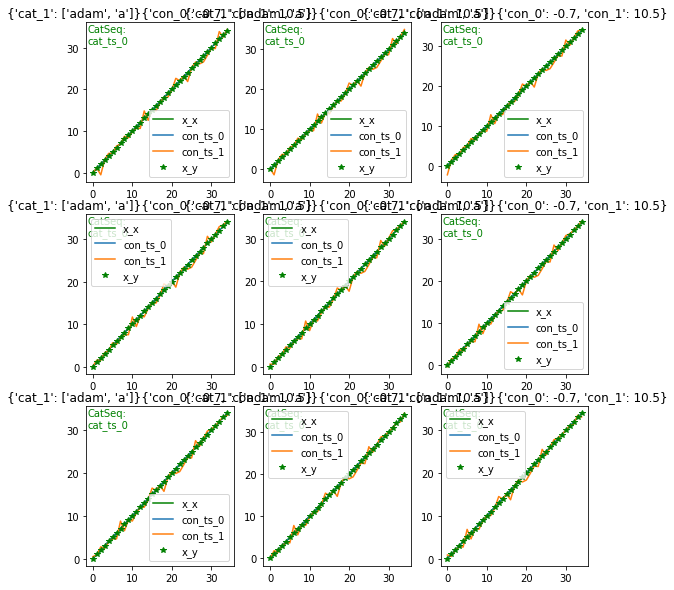

In [35]:
path = Path('../data/test_data')
path.delete()
horizon,lookback = 7, 28
df = get_df([80, 80, 80])
path.mkdir()
save_df(df, path)
dls = MTSDataLoaders.from_m5_path(path, 'x', horizon=horizon, lookback=lookback, num_workers = 1)
dls.show_batch()

In [36]:
%%time
for i,o in enumerate(dls.train):
    pass

CPU times: user 1.73 ms, sys: 74.2 ms, total: 75.9 ms
Wall time: 122 ms


In [37]:
# export
@delegates(MTSDataLoaders._from_folders_list)
def from_path(cls, path:Path, y_name:str, horizon:int, lookback = None, valid_pct = 1.5, **kwargs):
    """Create `MTSDataLoaders` from a path. 
    Defaults to splitting in train and validation set.    
    """    
    lookback = ifnone(lookback, horizon * 3)
    vocab, o2i = make_vocab(path)                
    train, valid = get_train_valid_ts(path, horizon = horizon, lookback = lookback, valid_pct= valid_pct)
    return cls._from_folders_list(folders = [train, valid], y_name= y_name, horizon= horizon, lookback = lookback, 
                                  vocab=vocab, o2i=o2i, path = path, **kwargs)

MTSDataLoaders.from_path = classmethod(from_path)

In [38]:
show_doc(MTSDataLoaders.from_path, name= 'MTSDataLoaders.from_path')

<h4 id="MTSDataLoaders.from_path" class="doc_header"><code>MTSDataLoaders.from_path</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>MTSDataLoaders.from_path</code>(**`path`**:`Path`, **`y_name`**:`str`, **`horizon`**:`int`, **`lookback`**=*`None`*, **`valid_pct`**=*`1.5`*, **`step`**=*`1`*, **`device`**=*`None`*, **`norm`**=*`True`*, **`splitter`**=*`None`*, **`procs`**=*`None`*, **`vocab`**=*`None`*, **`o2i`**=*`None`*, **`min_seq_len`**=*`None`*, **`train`**=*`True`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`verbose`**=*`False`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create [`MTSDataLoaders`](/fastseq/data.core#MTSDataLoaders) from a path. 
Defaults to splitting in train and validation set.    

In [ ]:
path = Path('../data/test_data')
path.delete()
horizon,lookback = 7, 14
df = get_df([80, 80, 80])
path.mkdir()
save_df(df, path)
dls = MTSDataLoaders.from_path(path, 'x', horizon=horizon, lookback=lookback, num_workers = 1)
dls.show_batch()

{'Train': 87, 'Val': 33}


In [40]:
# export
@delegates(MTSDataLoaders._from_folders_list)    
def from_folders(cls, folders:List[Path], y_name:str, horizon:int, **kwargs):
    """Create `MTSDataLoaders` from the folders."""        
    folders = [get_files(path, extensions='.json', folders = False) for path in folders]
    vocab, o2i = make_vocab(folders[0][0].parent.parent)     
    return cls._from_folders_list(folders, y_name, horizon,vocab=vocab, o2i=o2i, **kwargs)
    
MTSDataLoaders.from_folders = classmethod(from_folders)


In [41]:
show_doc(MTSDataLoaders.from_folders, name='MTSDataLoaders.from_folders')

<h4 id="MTSDataLoaders.from_folders" class="doc_header"><code>MTSDataLoaders.from_folders</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>MTSDataLoaders.from_folders</code>(**`folders`**:`List`\[`Path`\], **`y_name`**:`str`, **`horizon`**:`int`, **`lookback`**=*`None`*, **`step`**=*`1`*, **`device`**=*`None`*, **`norm`**=*`True`*, **`valid_pct`**=*`1.5`*, **`splitter`**=*`None`*, **`procs`**=*`None`*, **`vocab`**=*`None`*, **`o2i`**=*`None`*, **`path`**=*`None`*, **`min_seq_len`**=*`None`*, **`train`**=*`True`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`verbose`**=*`False`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create [`MTSDataLoaders`](/fastseq/data.core#MTSDataLoaders) from the folders.

{'Train': 87, 'Val': 33}


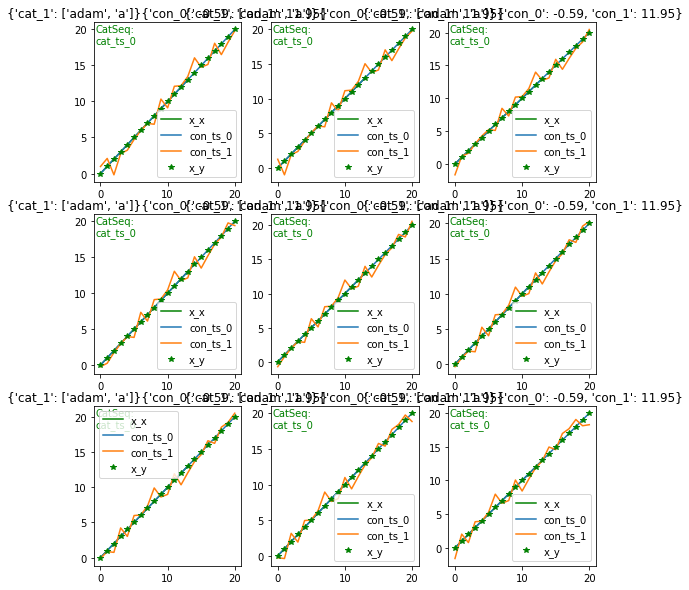

In [42]:
path = Path('../data/test_data')
dls = MTSDataLoaders.from_folders([path / 'train', path / 'valid'], 'x', horizon=horizon, lookback=lookback, num_workers = 1)
dls.show_batch()

In [44]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 00_m5.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.procs.ipynb.
Converted 05_data.m5.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
Converted tab.model.ipynb.


In [77]:
git_add('03_data.core.ipynb', commit_msg='name `path is not defined`')

Converted 03_data.core.ipynb.


['/home/tako/dev/fastseq/fastseq/data/core.py',
 '/home/tako/dev/fastseq/nbs/03_data.core.ipynb']